### Булгаков Арсений, ВМК, 116 группа

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from scipy.stats import bootstrap
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [2]:
%config InlineBackend.figure_formats = ['svg']
sns.set_theme(style='darkgrid')

In [3]:
data = pd.read_csv("/Users/arsenij/Downloads/flights_NY.csv")
data.dropna(inplace=True)

In [4]:
data.head()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance
0,2013,1,1,517.0,2.0,830.0,11.0,UA,N14228,1545,EWR,IAH,227.0,1400
1,2013,1,1,533.0,4.0,850.0,20.0,UA,N24211,1714,LGA,IAH,227.0,1416
2,2013,1,1,542.0,2.0,923.0,33.0,AA,N619AA,1141,JFK,MIA,160.0,1089
3,2013,1,1,544.0,-1.0,1004.0,-18.0,B6,N804JB,725,JFK,BQN,183.0,1576
4,2013,1,1,554.0,-6.0,812.0,-25.0,DL,N668DN,461,LGA,ATL,116.0,762


## 1

In [5]:
def calc_proba(x):
    num_positive_delays = (x.values > 0).sum()
    num_all_delays = x.values.shape[0]
    return num_positive_delays / num_all_delays

In [6]:
probs = data.groupby("carrier")["arr_delay"].agg([calc_proba]).rename(columns={"calc_proba": "proba"}).reset_index()
probs

,carrier,proba
0,9E,0.383775
1,AA,0.335118
2,AS,0.266573
3,B6,0.436807
4,DL,0.344391
5,EV,0.479064
6,F9,0.575624
7,FL,0.596850
8,HA,0.283626
9,MQ,0.467029


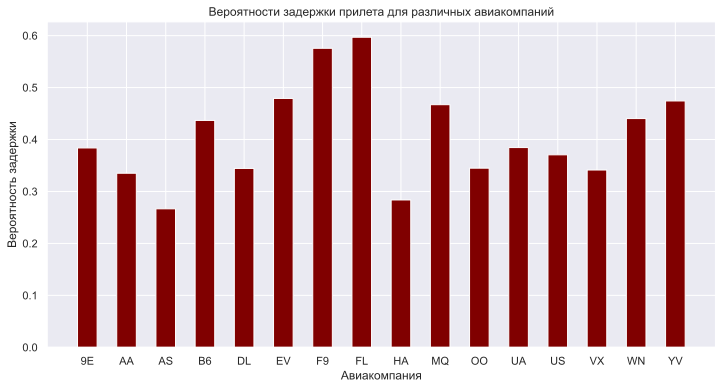

In [7]:
plt.figure(figsize=(12, 6))
plt.bar(probs["carrier"], probs["proba"], color ='maroon', width = 0.5)
plt.xlabel("Авиакомпания")
plt.ylabel("Вероятность задержки")
plt.title("Вероятности задержки прилета для различных авиакомпаний")
plt.show()

## 2

В качестве границ для групп возьмем 0.1й и 0.9й квантили

Тогда:
* "короткие перелеты" - 10% самых коротких
* "длинные перелеты" - 10% самых длинных
* "средние перелеты" - все остальные

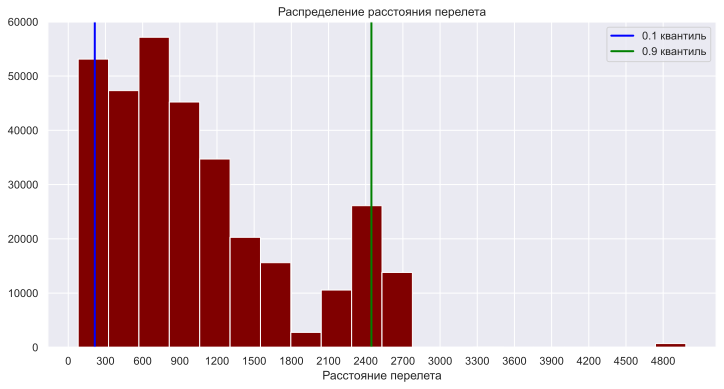

In [8]:
plt.figure(figsize=(12, 6))
plt.hist(data["distance"], bins=20, color ='maroon')
plt.axvline(data["distance"].quantile(0.1), color='blue', linewidth=2)
plt.axvline(data["distance"].quantile(0.9), color='green', linewidth=2)
plt.legend(["0.1 квантиль", "0.9 квантиль"])
plt.xlabel("Расстояние перелета")
plt.title("Распределение расстояния перелета")
plt.xticks(range(0, data["distance"].max(), 300))
plt.show()

In [9]:
list(data[data["distance"] > data["distance"].quantile(0.9)]["dest"].unique())

['LAX', 'SFO', 'HNL', 'LGB', 'BUR', 'PDX', 'SJC', 'OAK', 'SMF', 'ANC']

Список аэропортов, в которые прилетают самолеты из группы "длинных" перелетов

* LAX - Аэропорт в Лос-Анджелесе, Калифорния
* SFO - Международный аэропорт в Калифорнии
* HNL - Коммерческий аэропорт в Гонолулу, Гавайи
* LGB - Аэропорт в Калифорнии
* BUR - Аэропорт в Калифорнии
* PDX - Аэропорт в Портленде, Орегон
* SJC - Международный аэропорт в Калифорнии
* OAK - Международный аэропорт в Калифорнии
* SMF - Международный аэропорт в Калифорнии
* ANC - Аэропорт в Анкоридже, Аляска


В основном самолеты из группы "длинных" перелетов летают в штат Калифорния

In [10]:
DISTANCE_Q01 = data["distance"].quantile(0.1)
DISTANCE_Q09 = data["distance"].quantile(0.9)

In [11]:
def get_flight_category(x):
    if x > DISTANCE_Q09:
        return "long"
    elif x < DISTANCE_Q01:
        return "short"
    else:
        return "medium"

In [12]:
data["flight_group"] = data["distance"].apply(get_flight_category)

In [13]:
flight_groups = data.groupby("flight_group")["arr_delay"].agg(['mean']).reset_index()
flight_groups

,flight_group,mean
0,long,1.769740
1,medium,7.520038
2,short,6.928124


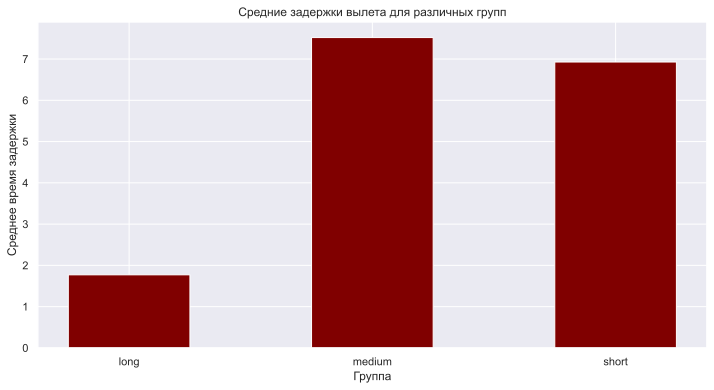

In [14]:
plt.figure(figsize=(12, 6))
plt.bar(flight_groups["flight_group"], flight_groups["mean"], color ='maroon', width = 0.5)
plt.xlabel("Группа")
plt.ylabel("Среднее время задержки")
plt.title("Средние задержки вылета для различных групп")
plt.show()

## 3

Построим доверительные интервалы для средного времени задержки с помощью бутстрепа

In [15]:
def get_conf_interval(x):
    res = bootstrap((x.values,), np.mean, confidence_level=0.95, random_state=1, method='percentile')
    low = res.confidence_interval.low
    high = res.confidence_interval.high
    
    return [low, high]

In [16]:
delays_months = data.groupby("month")["arr_delay"].agg(["mean", get_conf_interval]).rename(columns={"get_conf_interval": "conf_interval"}).reset_index()
delays_months

,month,mean,conf_interval
0,1,6.129972,"[5.641220925827715, 6.624713993484355]"
1,2,5.613019,"[5.1136334759222395, 6.118326203888018]"
2,3,5.807577,"[5.2976829617948535, 6.338221274460612]"
3,4,11.176063,"[10.618188579306342, 11.74381258162821]"
4,5,3.521509,"[2.9987343572241185, 4.032074800910125]"
5,6,16.481330,"[15.826459833795013, 17.17687719298246]"
6,7,16.711307,"[16.03931537836214, 17.37375675962252]"
7,8,6.040652,"[5.549603560995966, 6.537070524412297]"
8,9,-4.018364,"[-4.48227878563495, -3.546865975564606]"
9,10,-0.167063,"[-0.5348644209937801, 0.21845866238031966]"


In [17]:
delays_months["low"] = delays_months["conf_interval"].apply(lambda x: x[0])
delays_months["high"] = delays_months["conf_interval"].apply(lambda x: x[1])

delays_months["low"] = delays_months["mean"] - delays_months["low"]
delays_months["high"] = delays_months["high"] - delays_months["mean"]

In [18]:
delays_months

,month,mean,conf_interval,low,high
0,1,6.129972,"[5.641220925827715, 6.624713993484355]",0.488751,0.494742
1,2,5.613019,"[5.1136334759222395, 6.118326203888018]",0.499386,0.505307
2,3,5.807577,"[5.2976829617948535, 6.338221274460612]",0.509894,0.530645
3,4,11.176063,"[10.618188579306342, 11.74381258162821]",0.557874,0.567750
4,5,3.521509,"[2.9987343572241185, 4.032074800910125]",0.522774,0.510566
5,6,16.481330,"[15.826459833795013, 17.17687719298246]",0.654870,0.695548
6,7,16.711307,"[16.03931537836214, 17.37375675962252]",0.671991,0.662450
7,8,6.040652,"[5.549603560995966, 6.537070524412297]",0.491049,0.496418
8,9,-4.018364,"[-4.48227878563495, -3.546865975564606]",0.463915,0.471498
9,10,-0.167063,"[-0.5348644209937801, 0.21845866238031966]",0.367802,0.385521


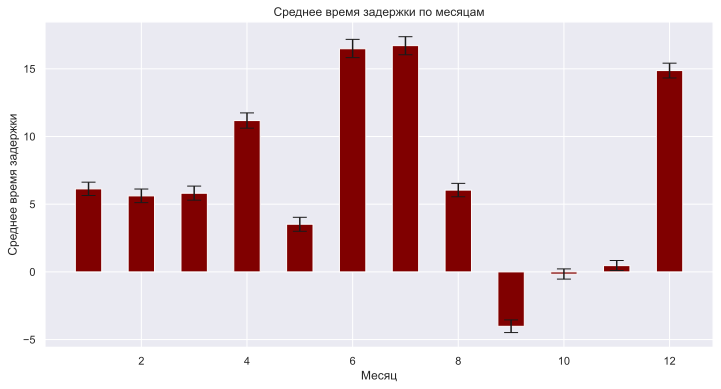

In [19]:
plt.figure(figsize=(12, 6))
plt.bar(delays_months["month"], delays_months["mean"], color ='maroon', width = 0.5, yerr=delays_months.loc[:, ["low", "high"]].values.T, capsize=7)
plt.xlabel("Месяц")
plt.ylabel("Среднее время задержки")
plt.title("Среднее время задержки по месяцам")
plt.show()

Проверим гипотезу о равенстве средних с помощью t-test

In [20]:
np.var(data[data["month"] == 1]["arr_delay"].values)

1634.0295880816448

In [21]:
np.var(data[data["month"] == 2]["arr_delay"].values)

1562.4455193702154

In [22]:
first_month = data[data["month"] == 1]["arr_delay"].values
second_month = data[data["month"] == 2]["arr_delay"].values
stats.ttest_ind(first_month, second_month, equal_var=False)

Ttest_indResult(statistic=1.4444786914681855, pvalue=0.1486106846960724)

p-value > 0.05 -> гипотеза о равенстве средних не отвергается на уровне значимости 0.05 
На уровне значимости 0.01 гипотеза также не отвергается

## 4

Посчитаем коэффициент корреляции Спирмена

In [23]:
np.corrcoef(data["distance"].values, data["air_time"].values)[0, 1]

0.9906496472248592

In [24]:
m, b = np.polyfit(data["distance"].values, data["air_time"].values, 1)

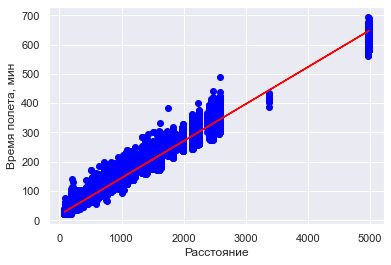

In [25]:
%config InlineBackend.figure_formats = ["png"]
plt.scatter(data["distance"].values, data["air_time"].values, c ="blue")
plt.plot(data["distance"].values, m*data["distance"].values+b, c="red")
plt.ylabel("Время полета, мин")
plt.xlabel("Расстояние")
plt.show()
%config InlineBackend.figure_formats = ["svg"]

In [26]:
m

0.12611932467384995

In [27]:
b

18.46657812775938

Коэффициенты можно проинтерпретировать так: если расстояние полета увеличилось на 1 (км?), то время полета увеличится в среднем на 0.12 минуты

## 5

In [28]:
tmp = data[(data["dep_delay"] >= -15) & (data["dep_delay"] <= 15)]
tmp

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,flight_group
0,2013,1,1,517.0,2.0,830.0,11.0,UA,N14228,1545,EWR,IAH,227.0,1400,medium
1,2013,1,1,533.0,4.0,850.0,20.0,UA,N24211,1714,LGA,IAH,227.0,1416,medium
2,2013,1,1,542.0,2.0,923.0,33.0,AA,N619AA,1141,JFK,MIA,160.0,1089,medium
3,2013,1,1,544.0,-1.0,1004.0,-18.0,B6,N804JB,725,JFK,BQN,183.0,1576,medium
4,2013,1,1,554.0,-6.0,812.0,-25.0,DL,N668DN,461,LGA,ATL,116.0,762,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336765,2013,9,30,2240.0,-5.0,2334.0,-17.0,B6,N354JB,1816,JFK,SYR,41.0,209,short
336766,2013,9,30,2240.0,-10.0,2347.0,-20.0,B6,N281JB,2002,JFK,BUF,52.0,301,medium
336767,2013,9,30,2241.0,-5.0,2345.0,-16.0,B6,N346JB,486,JFK,ROC,47.0,264,medium
336768,2013,9,30,2307.0,12.0,2359.0,1.0,B6,N565JB,718,JFK,BOS,33.0,187,short


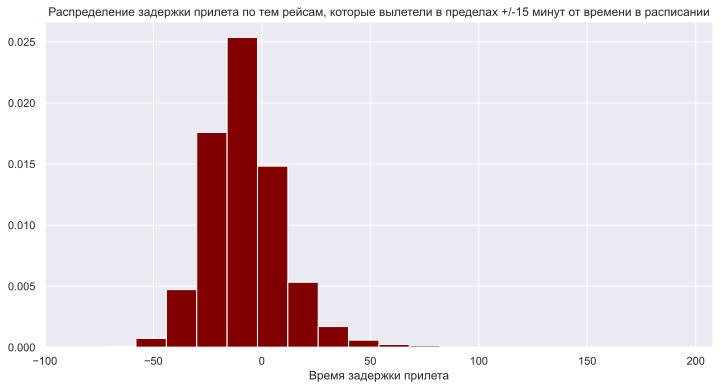

In [29]:
plt.figure(figsize=(12, 6))
plt.hist(tmp["arr_delay"], bins=20, color ='maroon', density=True)
plt.xlabel("Время задержки прилета")
plt.title("Распределение задержки прилета по тем рейсам, которые вылетели в пределах +/-15 минут от времени в расписании")
plt.show()

Визуально распределение похоже на нормальное, попробуем оценить его параметры по выборке и изобразить плотность

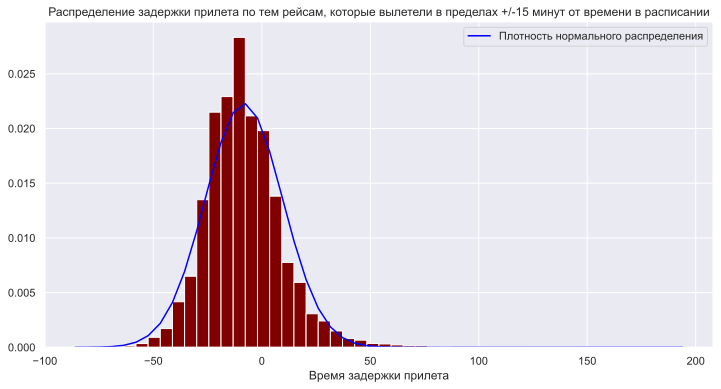

In [30]:
plt.figure(figsize=(12, 6))
_, bins, _ = plt.hist(tmp["arr_delay"], bins=50, color ='maroon', density=True)
mu, sigma = stats.norm.fit(tmp["arr_delay"])
best_fit_line = stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line, c="blue")
plt.legend(["Плотность нормального распределения"])
plt.xlabel("Время задержки прилета")
plt.title("Распределение задержки прилета по тем рейсам, которые вылетели в пределах +/-15 минут от времени в расписании")
plt.show()

Проверим гипотезу о нормальности с помощью критерия Колмогорова-Смирнова

In [31]:
stats.kstest(tmp["arr_delay"].values, 'norm')

KstestResult(statistic=0.677518258845786, pvalue=0.0)

p-value << 0.05 -> гипотеза о нормальности отвергается

## 6

В качестве факторов из исходного датасета время задержки вылета, расстояние полета, а также месяц, авиакомпаниюю, аэропорты вылета и прилета (категориальные факторы закодируем с помощью OneHot)

In [32]:
data["target"] = (data["arr_delay"] > 15).astype(int)

In [33]:
y = data.loc[:, ["target"]]
X = data.loc[:, ["month", "dep_delay", "carrier", "origin", "dest", "distance"]]

Разобьем выборку на обучающую и валидационную

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [35]:
X_train.head()

,month,dep_delay,carrier,origin,dest,distance
183843,4,-5.0,DL,LGA,MSP,1020
81618,11,-2.0,9E,JFK,RIC,288
313915,9,-3.0,US,JFK,CLT,541
263847,7,7.0,UA,EWR,SFO,2565
58370,11,-9.0,B6,JFK,MCO,944


In [36]:
one_hot_month = pd.get_dummies(data["month"])
one_hot_carrier = pd.get_dummies(data["carrier"])
one_hot_origin = pd.get_dummies(data["origin"])
one_hot_dest = pd.get_dummies(data["dest"])

X_train = X_train.join(one_hot_month)
X_train = X_train.join(one_hot_carrier)
X_train = X_train.join(one_hot_origin)
X_train = X_train.join(one_hot_dest)


X_val = X_val.join(one_hot_month)
X_val = X_val.join(one_hot_carrier)
X_val = X_val.join(one_hot_origin)
X_val = X_val.join(one_hot_dest)

X_train = X_train.drop(["month", "carrier", "origin", "dest"], axis=1)
X_val = X_val.drop(["month", "carrier", "origin", "dest"], axis=1)

In [37]:
X_train.head()

,dep_delay,distance,1,2,3,4,5,6,7,8,...,SNA,SRQ,STL,STT,SYR,TPA,TUL,TVC,TYS,XNA
183843,-5.0,1020,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
81618,-2.0,288,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313915,-3.0,541,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263847,7.0,2565,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
58370,-9.0,944,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
model = LogisticRegression(random_state=0, max_iter=1000).fit(X_train.to_numpy(), y_train.to_numpy().reshape(-1))

In [39]:
y_pred = model.predict_proba(X_val.to_numpy())[:, 1]

In [40]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

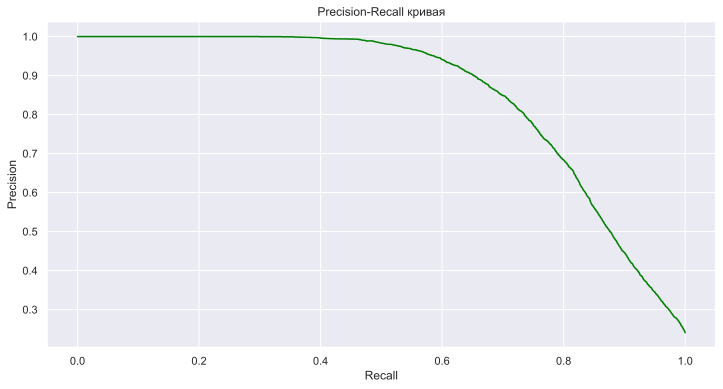

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(recall, precision, c="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall кривая")
plt.show()

In [42]:
roc_auc = roc_auc_score(y_val, y_pred)
print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.9075197027658767


Посмотрим на метркии precision, recall, accuracy при пороге бинаризации 0.5

In [43]:
y_pred = model.predict(X_val.to_numpy())

In [44]:
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

Precision: 0.8802992518703242
Recall: 0.671613394216134
Accuracy: 0.8989155338322896
